In [1]:
#IMPORT REQUIRED LIBRARIES
import pandas as pd #data manipulation/analysis
import numpy as np #numerical operations
import matplotlib.pyplot as plt #plotting
import seaborn as sns #statisticals visualizations
from sklearn.model_selection import train_test_split #training/testing sets
from sklearn.ensemble import RandomForestRegressor  # Use regressor instead of classifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib   #saving/loading trained models

In [2]:

#LOAD DATASETS
#these data sets contain features and target data we need 
#for our project/model
weather_data = pd.read_csv("all_conditions.csv")
wildfire_data = pd.read_csv("California_Fire_Incidents_utf8.csv")
forest_fires = pd.read_csv("forestfires.csv")

In [3]:
#EXPLORATORY
#display first few rows
#examine basic info about the datasets

#Descriptive Stats
#weather dataset
print("Weather Data Summary: \n", weather_data.describe())
#wildfire dataset
print("\nWildfire Data Summary: \n", wildfire_data.describe())
#forest fire dataset
print("\nForest Fires Data Summary: \n", forest_fires.describe()) 

Weather Data Summary: 
               Stn Id       ETo (in)    Precip (in)  Sol Rad (Ly/day)  \
count  128125.000000  128042.000000  128125.000000     128125.000000   
mean      157.257686       0.157898       0.038263        458.957136   
std        72.576703       0.086695       0.202978        198.349566   
min         2.000000       0.000000       0.000000          0.000000   
25%        99.000000       0.080000       0.000000        301.000000   
50%       171.000000       0.150000       0.000000        471.000000   
75%       219.000000       0.230000       0.000000        633.000000   
max       262.000000       0.490000      13.610000       6618.000000   

       Avg Vap Pres (mBars)  Max Air Temp (F)  Min Air Temp (F)  \
count         128125.000000     128122.000000     128124.000000   
mean              11.285094         75.279722         48.495665   
std                4.105851         14.742913         11.430017   
min                0.000000         24.900000         -5.00

In [4]:
#display first few lines of the datasets
#weather dataset
print("Weather Data Summary: \n", weather_data.head())
#wildfire dataset
print("\nWildfire Data Summary: \n", wildfire_data.head())
#forest fire dataset
print("\nForest Fires Data Summary: \n", forest_fires.head()) 

Weather Data Summary: 
    Stn Id    Stn Name        CIMIS Region      Date  ETo (in)  Precip (in)  \
0       2  FivePoints  San Joaquin Valley  1/1/2018      0.06         0.00   
1       2  FivePoints  San Joaquin Valley  1/2/2018      0.04         0.00   
2       2  FivePoints  San Joaquin Valley  1/3/2018      0.04         0.00   
3       2  FivePoints  San Joaquin Valley  1/4/2018      0.07         0.01   
4       2  FivePoints  San Joaquin Valley  1/5/2018      0.07         0.00   

   Sol Rad (Ly/day)  Avg Vap Pres (mBars)  Max Air Temp (F)  Min Air Temp (F)  \
0             219.0                   7.3              63.4              35.3   
1             127.0                   7.4              59.8              37.7   
2             125.0                   8.4              61.1              37.3   
3             219.0                  11.6              69.2              48.7   
4             239.0                  12.7              73.8              47.5   

   Avg Air Temp (F) 

In [5]:
#check for missing values
#If critical data like temperature
#or fire occurrence is missing, it can impact predictions. 
#We decide here how to handle them—whether to drop, fill, or interpolate
print("\nMissing Values in Weather Data:\n", weather_data.isnull().sum())
print("\nMissing Values in Wildfire Data:\n", wildfire_data.isnull().sum())
print("\nMissing Values in Forest Fires Data:\n", forest_fires.isnull().sum())



Missing Values in Weather Data:
 Stn Id                   0
Stn Name                 0
CIMIS Region             0
Date                     0
ETo (in)                83
Precip (in)              0
Sol Rad (Ly/day)         0
Avg Vap Pres (mBars)     0
Max Air Temp (F)         3
Min Air Temp (F)         1
Avg Air Temp (F)         5
Max Rel Hum (%)          0
Min Rel Hum (%)          0
Avg Rel Hum (%)         13
Dew Point (F)           13
Avg Wind Speed (mph)     0
Wind Run (miles)         0
Avg Soil Temp (F)       20
Target                   0
dtype: int64

Missing Values in Wildfire Data:
 AcresBurned                3
Active                     0
AdminUnit                  0
AirTankers              1608
ArchiveYear                0
CalFireIncident            0
CanonicalUrl               0
ConditionStatement      1352
ControlStatement        1531
Counties                   0
CountyIds                  0
CrewsInvolved           1465
Dozers                  1513
Engines                 1445

In [6]:
#Handle missing values (example: fill with mean or drop)
weather_data.fillna(weather_data.select_dtypes(include=[np.number]).mean(), inplace=True)
wildfire_data.dropna(subset=['AcresBurned', 'Started'], inplace=True)  # Drop if critical columns are missing
forest_fires.fillna(0, inplace=True)

# Explanation: 
# - For weather_data, we fill missing numerical values with their mean to avoid data loss while preserving the distribution.
# - For wildfire_data, we drop rows missing 'AcresBurned' or 'Started' as they are critical for fire analysis.
# - For forest_fires, we fill any missing values with 0 since this dataset has less complexity and a synthetic structure.

In [7]:
#CONVERT DATES TO DATETIME FORMAT
#convert data columns to datetime format for proper
#alignment and merging of datasets later

#convert weather dates
#convert fire start dates
weather_data['Date'] = pd.to_datetime(weather_data['Date'], errors='coerce')  # Coerce invalid formats to NaT
wildfire_data['Started'] = pd.to_datetime(wildfire_data['Started'], errors='coerce')

#since dataset doesn't provide year info, we create synthetic dates based on the month
#assuming single year (create synthetic dates for the forestfires dataset)
forest_fires['synthetic_date'] = pd.to_datetime(
    forest_fires['month'] + '-01-2023', format='%b-%d-%Y' 
) #create synthetic dates based on month


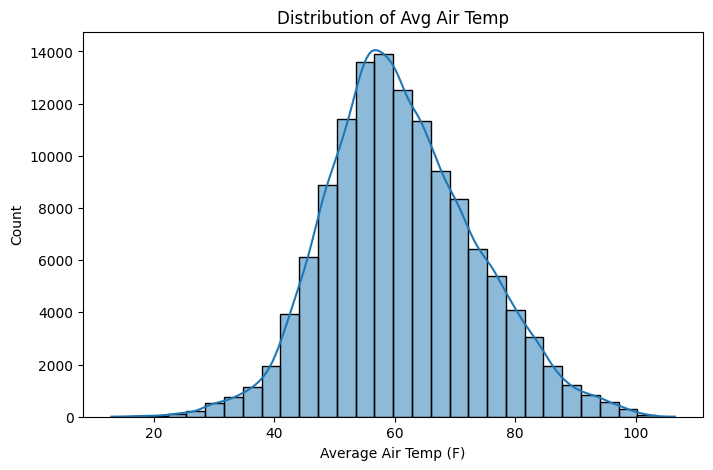

In [8]:
#EXPLORATORY ANALYSIS WITH PLOTS
#visualize key features to understand the distribution
#and patterns in the data

plt.figure(figsize=(8,5)) #set figure size
#disbribution of temperature
sns.histplot(weather_data['Avg Air Temp (F)'], bins=30, kde=True) 
plt.title('Distribution of Avg Air Temp')
plt.xlabel('Average Air Temp (F)')
plt.show()

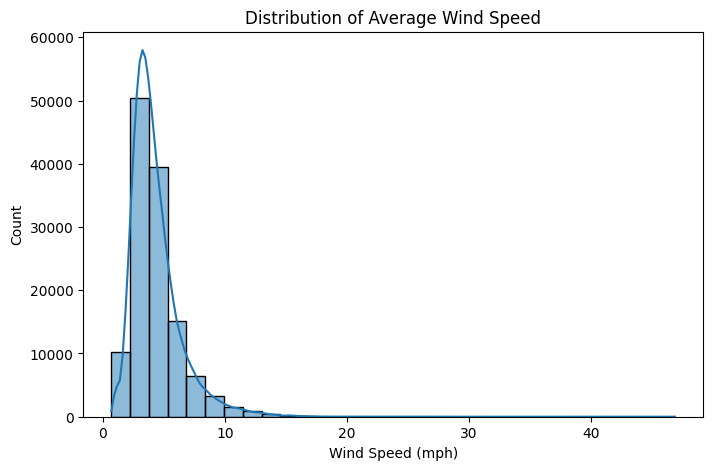

In [9]:
plt.figure(figsize=(8,5)) #set figure size
#Distribution of wind speed
sns.histplot(weather_data['Avg Wind Speed (mph)'], bins=30, kde=True)
plt.title('Distribution of Average Wind Speed')
plt.xlabel('Wind Speed (mph)')
plt.show()

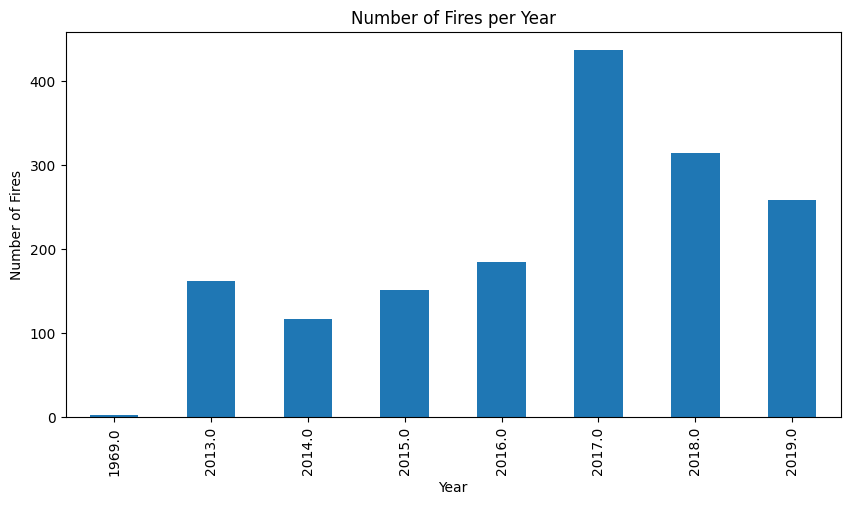

In [10]:
plt.figure(figsize=(10,5)) #set figure size
#fires per year
wildfire_data['Started'].groupby(wildfire_data['Started'].dt.year).count().plot(kind='bar')
plt.title('Number of Fires per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.show()

In [11]:
#AGGREGATE WILDFIRE INCIDENTS BY DATE AND 
#MERGE WITH WEATHER DATA
#aggregating the wildfire data by date so we can create features
#representing the total number of fires and acres burned per day

fire_daily = wildfire_data.groupby(wildfire_data['Started'].dt.date).agg(
    total_acres_burned=('AcresBurned', 'sum'), #total acres burned per day
    num_fires=('Started', 'count') #number of fires per day
).reset_index()

fire_daily.rename(columns={'Started':'Date'}, inplace=True) #rename for merging
fire_daily['Date'] = pd.to_datetime(fire_daily['Date']) #ensure date column is datetime


In [12]:
# Merge weather and wildfire data on 'Date'
# "Left-join" to retain all weather data and attach corresponding fire data (if available)
merged_data = pd.merge(weather_data, fire_daily, on='Date', how='left')

# Fill missing fire data with 0 (days without fires)
# Using the recommended syntax to avoid chained assignment warnings
merged_data = merged_data.fillna({
    'total_acres_burned': 0,  # No fire means 0 acres burned
    'num_fires': 0  # No fire incidents
})




In [13]:
#AGGREGATE FOREST FIRES BY MONTH AND 
#MERGE WITH MAIN DATASET
#summarize the forest fire data by month to 
#generate features such as avg temp, wind, and fire area burned

forest_fires_agg = forest_fires.groupby('month').agg(
    avg_temp=('temp', 'mean'), #avg temp per month
    avg_wind=('wind', 'mean'), #avg wind speed per month
    avg_humidity=('RH', 'mean'), #avg humidity per month
    avg_fire_area=('area', 'mean') #avg fire area burned per month 
).reset_index()


In [14]:
#merge the aggregated forest fire features on month
#this will allow us to introduce general monthly fire-related
#variables into our main dataset

merged_data = pd.merge(
    merged_data, 
    forest_fires_agg,
    left_on=merged_data['Date'].dt.month.map(
        {
            1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr',
            5: 'may', 6: 'jun', 7: 'jul', 8: 'aug',
            9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'}),
    right_on='month',
    how='left'
)
merged_data.fillna(0, inplace=True) #fill missing values with 0

In [15]:
#FEATURE ENGINEERING
#create lagged features and seasonal indicators to capture temporal
#dependencies in the data

#lagged temperature and wind speed (from previous day)
merged_data['lag_1_temp']=merged_data['Avg Air Temp (F)'].shift(1) 
merged_data['lag_1_wind']=merged_data['Avg Wind Speed (mph)'].shift(1)

#create a seasonal feature based on the month
#to help understand seasonal patterns (such as dry vs wet seasons)
merged_data['season']=merged_data['Date'].dt.month.map(
    lambda x:   'Winter' if x in [12, 1, 2] else
                'Spring' if x in [3, 4, 5] else
                'Summer' if x in [6, 7, 8] else 
                'Fall'
)
merged_data.fillna(0, inplace=True) #fill NaNs created by lagging with 0

In [16]:
# TRAIN-TEST SPLIT FOR REGRESSION

# Drop unnecessary columns to prepare the feature set
X = merged_data.drop(columns=['Date', 'total_acres_burned', 'num_fires'])  # Features

#--------
# "One-hot" encode categorical variables 
# because Random Forest Regressor only takes numerics
# Convert categorical features (like location or season) into binary columns
X = pd.get_dummies(X, drop_first=True)   # Automatically handles all object or category columns
#--------

# Target variable for regression: total acres burned
y = merged_data['total_acres_burned']  

# Split the data (80% training, 20% testing)
# random_state=42 ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
#TRAIN A RANDOM FOREST REGRESSOR
# Train a Random Forest model, suitable for non-linear data and interpretable via feature importance

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 decision trees (default)

# Train the regression model using the training data
rf.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [18]:
#EVALUATE THE REGRESSION MODEL

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model using regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display regression evaluation metrics
print("Regression Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)  # Average absolute error in burned area prediction
print("Mean Squared Error (MSE):", mse)  # Penalizes larger errors more heavily
print("R² Score (Explained Variance):", r2)  # How much of the variance in the data is explained by the model


Regression Evaluation Metrics:
Mean Absolute Error (MAE): 7174.584359024389
Mean Squared Error (MSE): 4010934836.796129
R² Score (Explained Variance): -0.11373998249509709


In [19]:
#ATTEMPT TO IMPROVE THE MODEL

# Log-transform the target variable to handle skewness and stabilize the variance
y_train_log = np.log1p(y_train)  # log(1 + burned area) to avoid log(0) issues
y_test_log = np.log1p(y_test)

# Train a Gradient Boosting Regressor, which can handle complex relationships better
improved_model = GradientBoostingRegressor(
    n_estimators=200,  # More trees for better performance
    learning_rate=0.1,  # Standard learning rate
    max_depth=5,  # Reasonable depth to avoid overfitting
    random_state=42
)

# Train the model on log-transformed target
improved_model.fit(X_train, y_train_log)


GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=42)

In [20]:

# Make predictions on the test set
y_pred_log = improved_model.predict(X_test)

# Transform predictions back to the original scale (inverse of log1p)
y_pred = np.expm1(y_pred_log)

# Evaluate the improved model using regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics and what they mean 
print("Improved Model Regression Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae, 
      "- On average, the model's predictions are off by this many acres.")
print("Mean Squared Error (MSE):", mse, 
      "- The average of the squared errors, penalizing larger errors more heavily.")
print("R² Score (Explained Variance):", r2, 
      "- The proportion of the variance in the actual burned area explained by the model.")


Improved Model Regression Evaluation Metrics:
Mean Absolute Error (MAE): 3627.8116012859405 - On average, the model's predictions are off by this many acres.
Mean Squared Error (MSE): 3613915929.690722 - The average of the squared errors, penalizing larger errors more heavily.
R² Score (Explained Variance): -0.0034973960054591746 - The proportion of the variance in the actual burned area explained by the model.


In [21]:
#SAVE MODEL TO A FILE

# Save the trained model to a file
joblib.dump(improved_model, 'wildfire_burned_area_model.pkl')



['wildfire_burned_area_model.pkl']

In [22]:
#SAVE PREPROCESSED DATASET FOR FUTURE USE/REVISIT

merged_data.to_csv('final_preprocessed_wildfire_data.csv', index=False)

In [31]:
#TEST CELL -- testing the model

import joblib
import pandas as pd
import numpy as np

# Save the list of features used for training 
joblib.dump(X_train.columns, 'expected_features.pkl')
print("Expected features saved.")

# Load the saved expected feature list and the trained model
expected_features = joblib.load('expected_features.pkl')
loaded_model = joblib.load('wildfire_burned_area_model.pkl')

# Example user-provided input (partial)
new_data = pd.DataFrame({
    'Avg Air Temp (F)': [80],
    'Avg Wind Speed (mph)': [10],
    'Precip (in)': [0.1],
    'log_wind_speed': [np.log1p(10)],  # Log transformation
    'dry_season': [1],  # 1 for dry season, 0 for not
    'season_Spring': [0]  # Assume not Spring for this test
})

# Reindex to match the expected feature set, filling any missing features with 0
new_data = new_data.reindex(columns=expected_features, fill_value=0)

# Make predictions using the loaded model
predicted_log_burned_area = loaded_model.predict(new_data)
predicted_burned_area = np.expm1(predicted_log_burned_area)  # Convert back from log scale

# Display prediction
print("\nPredicted Burned Area of Wildfire (in acres):", predicted_burned_area[0])


Expected features saved.

Predicted Burned Area of Wildfire (in acres): 18.56230569896174
